In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Создание модели HNN

In [ ]:
# Реализуем ее с помощью класса, так как у нас не классический учет ошибки
class HNN(tf.keras.Model):

  def __init__(self, shapes, activation='tanh'):
    super(HNN, self).__init__()
    self.input_layer = tf.keras.layers.Input(shapes[0], batch_size=70)
    self.hidden_layer_1 = tf.keras.layers.Dense(shapes[1], activation=activation)
    self.hidden_layer_2 = tf.keras.layers.Dense(shapes[2], activation=activation)
    self.output_layer = tf.keras.layers.Dense(1) # Один выходной слой всегда, поскольку мы создаем гамильтониан
    
    Mat = np.eye(shapes[0]) # Матрица, которая примет на вход производные, поменяет их местами и поставит минус
    Mat = np.concatenate([Mat[shapes[0] // 2:], -Mat[:shapes[0] // 2]], axis=0)
    self.Mat = tf.constant(Mat, dtype='float64')
    self.history_loss = []

  def call(self, x):
    y = self.hidden_layer_1(x)
    y = self.hidden_layer_2(y)
    return self.output_layer(y)

  def forward(self, x):
    with tf.GradientTape() as tape:
      y = self.hidden_layer_1(x)
      y = self.hidden_layer_2(y)
      y = self.output_layer(y)
    y = tape.gradient(y, x)
    y = y @ self.Mat
    return y

def fit_HNN(model, x, y, batch_size=36, learning_rate=1e-4, epochs=100, verbose = 10):
  
  loss_obj = tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for i in range(epochs):

    for batch in range(0, len(x), batch_size):
      
      with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables[:batch_size * batch])
        predictions = model.forward(tf.Variable(x[:batch_size * batch]))
        loss = loss_obj(tf.Variable(y[:batch_size * batch]), predictions)
      grads = tape.gradient(loss, model.trainable_variables[:batch_size * batch], unconnected_gradients='zero')
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    model.history_loss.append(loss)

    if verbose > 0:
      if i % verbose == 0:
        print(f' Step {i}: MSE: {loss.numpy()}')

  print(f'Last train Loss: {loss.numpy() : 0.8f}')

  return model

def integrate_HNN(model, t, y0, shapes, **kwargs):
  def S_h(t, x):
    x = tf.Variable(tf.reshape(x, (1, shapes[0])), dtype='double')
    dx = model.forward(x)
    return dx

  return solve_ivp(S_h, t, y0, **kwargs)


# Маятник

In [ ]:
args_of_pend = {'l' : 2, 'm':1, 'g':9.8}

def Hamiltonian(q, p, l, m, g):
  return ( p**2 / (2 * m * l ** 2)) + ( m*g*l * (1 - np.cos(q)) )

H = Hamiltonian

def S(t, pq = (1, 1), H=H, NN = False, h=1e-7):

  if NN:
    dqdt =  (H(  np.array([[pq[0], pq[1] + h]])  ) - H(   np.array([[pq[0], pq[1] - h]])     )) / (2*h)
    dpdt = -(H(  np.array([[pq[0] + h, pq[1]]])  ) - H(   np.array([[pq[0] - h, pq[1]]])     )) / (2*h)

  else:  
    dqdt =  (H(pq[0], pq[1] + h, **args_of_pend) - H(pq[0], pq[1] - h, **args_of_pend) ) / (2*h)
    dpdt = -(H(pq[0] + h, pq[1], **args_of_pend) - H(pq[0] - h, pq[1], **args_of_pend) ) / (2*h)

  S = np.array([dqdt, dpdt])

  return S

H = Hamiltonian
print(f'S(dqdt, dpdt) = {np.round( S(None, (-np.pi/2, 1), H), 4)}')

S(dqdt, dpdt) = [ 0.25 19.6 ]


In [ ]:
# Покажем как работает гамильтониан в числах
# Продифференциируем H по p и по q, получим S - вектор, показывающий напраление развития системы

qp0 = np.array([-np.pi/5, 2]) # Начальные параметры

# Если мы создадим гамильтониан в виде нейронной сети, зависимой от двух параметров, мы можем ее подставить в S.
H = Hamiltonian # / Или модель HNN

q, p = solve_ivp(fun = S,
                 t_span = [0, 9],
                 y0 = qp0,
                 t_eval = np.linspace(0, 9, 100),
                 args = (H, False))['y']


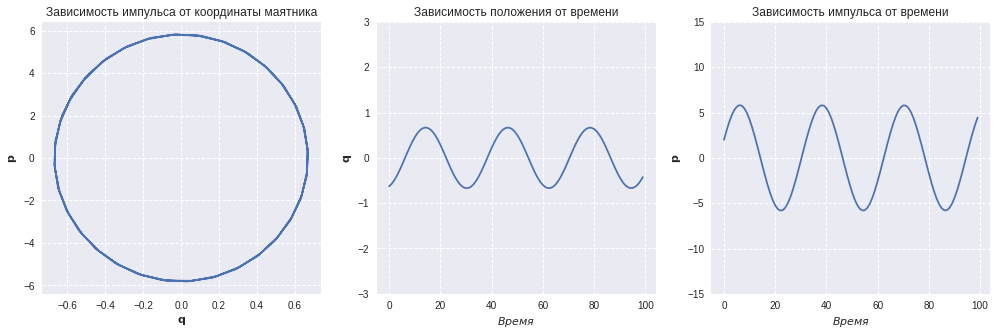

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].plot(q, p), ax[0].set_xlabel('$ \mathbf{q} $'), ax[0].grid(ls='--'), ax[0].axis('tight')
ax[0].set_ylabel('$ \mathbf{ p } $'), ax[0].set_title('Зависимость импульса от координаты маятника')

ax[1].plot(q), ax[1].set_xlabel('$ Время $'), ax[1].grid(ls='--'), ax[1].set_ylim(-3, 3)
ax[1].set_ylabel('$ \mathbf{ q } $'), ax[1].set_title('Зависимость положения от времени')

ax[2].plot(p), ax[2].set_xlabel('$ Время $'), ax[2].grid(ls='--'), ax[2].set_ylim(-15, 15)
ax[2].set_ylabel('$ \mathbf{ p } $'), ax[2].set_title('Зависимость импульса от времени')

print('')

# Создание данных

In [ ]:
# Будем реализовывать данные для обучения, как две пары координат - положение и импульс. Таким образом мы приблизимся к решению задач, в которых мало информации

def give_data(size=9, frames=72, qstarts = (-0.4, 0., 0.4), pstarts = (1., 1., 1.), length_pend=2, drop=None):

  time_end = frames / 24
  packs = []
  params = tf.random.shuffle(np.array(np.meshgrid(qstarts, pstarts)).reshape((2, len(qstarts) * len(pstarts))).T) # Декартово произведение всех состояний

  if drop != None:
    params = params[:drop]
  for i in range(size):
    q, p = solve_ivp(fun = S,
                 t_span = [0, time_end], 
                 method='RK45', 
                 y0 = params[i],
                 t_eval = np.linspace(0, time_end, frames, endpoint=True),
                 args = (H, False, 0.1))['y']

    dH = []
    for j in range(frames):
      dH.append(S(0, (q[j], p[j]) ))

    dH = np.array(dH)
    packs.append(np.reshape(np.concatenate((q, p, dH[:, 0], dH[:, 1]), axis=0), (4, frames)).T)
    
  return np.array(packs)


example_data = give_data(size=1, frames = 24, qstarts=[-1], pstarts=[1])
print(example_data[0, :3, :])

print('\n')
print(f'q1 = {example_data[0, 0, 0] :0.3f} + 1/24 * {example_data[0, 0, 2] :0.3f} = {example_data[0, 0, 0] + 1/24 * example_data[0, 0, 2] :0.5f}')

print(f'p1 = {example_data[0, 0, 1] :0.3f} + 1/24 * {example_data[0, 0, 3] :0.3f} = {example_data[0, 0, 1] + 1/24 * example_data[0, 0, 3] :0.5f}')

[[-1.          1.          0.25       16.49283131]
 [-0.98525048  1.71276934  0.42819233 16.33484667]
 [-0.9628074   2.4169107   0.60422767 16.08764941]]


q1 = -1.000 + 1/24 * 0.250 = -0.98958
p1 = 1.000 + 1/24 * 16.493 = 1.68720


In [ ]:
# Можно обучиться на 900 разных начальных состояниях
# data = give_data(size=30, frames=72, qstarts=np.linspace(-np.pi/2, np.pi/2, 30), pstarts=np.linspace(-10, 10, 30))
# data = np.concatenate(data, axis=0)
# x = data[:, :2]
# y = data[:, 2:]

# Обучение модели HNN

In [ ]:
data = give_data(size=50, frames=72, qstarts=np.linspace(-np.pi/2, np.pi/2, 5, endpoint=True), pstarts=np.linspace(-10, 10, 10, endpoint=True))
data = np.concatenate(data, axis=0)
x = data[:, :2]
y = data[:, 2:]

In [ ]:
hnn = HNN((2, 200, 200, 1))

hnn = fit_HNN(hnn, x, y, 72, 0.001, 100, 10)

 Step 0: MSE: 60.855323791503906
 Step 10: MSE: 0.19722604751586914
 Step 20: MSE: 0.042066335678100586
 Step 30: MSE: 0.018143238499760628
 Step 40: MSE: 0.01015724427998066
 Step 50: MSE: 0.005723961163312197
 Step 60: MSE: 0.002926368499174714
 Step 70: MSE: 0.0015805726870894432
 Step 80: MSE: 0.006563178263604641
 Step 90: MSE: 0.0006757378578186035
Last train Loss:  0.00035475


In [ ]:
#hnn.save('/content/drive/MyDrive/Курсовая/Pendulum/ModelBNN/ModelHNN')
q, p = integrate_HNN(hnn, [0, 3], x[0], (2, 200, 200, 2), t_eval=np.linspace(0, 3, 72))['y'] # (-1.57079633, -3.) - x[0] состояние из тренировочных данных

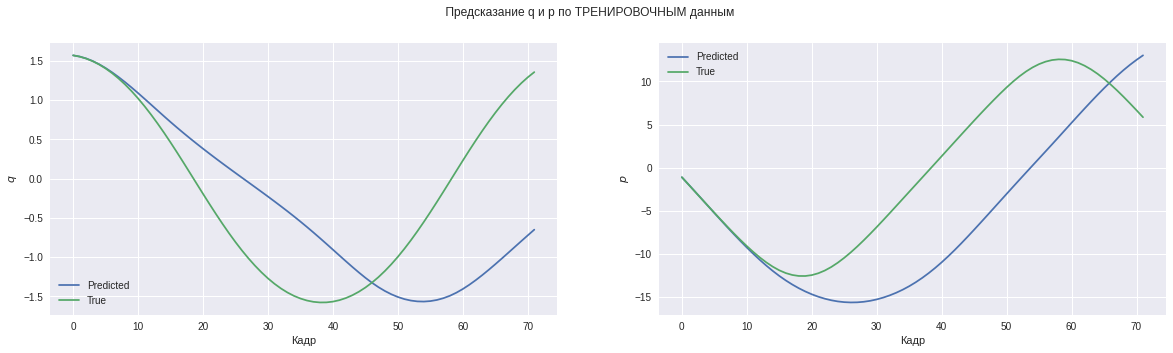

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

fig.suptitle(r' Предсказание q и p по ТРЕНИРОВОЧНЫМ данным ')

ax[0].plot(q, label='Predicted')
ax[0].plot(x[:72, 0], label='True')
ax[0].legend(), ax[0].set_xlabel('Кадр'), ax[0].set_ylabel('$q$')

ax[1].plot(p, label='Predicted')
ax[1].plot(x[:72, 1], label='True')
ax[1].legend(), ax[1].set_xlabel('Кадр'), ax[1].set_ylabel('$p$')

fig.savefig('/content/drive/MyDrive/Курсовая/Pendulum/result_HNN_by train', dpi=300)
print('')

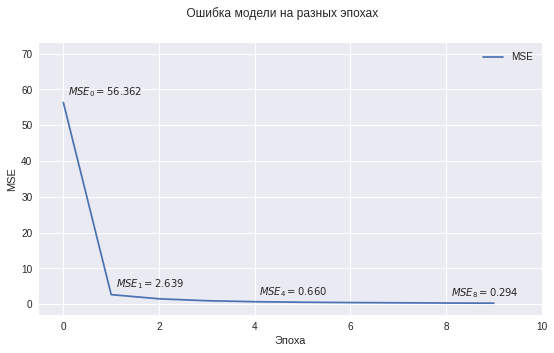

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

fig.suptitle(r' Ошибка модели на разных эпохах ')

ax.plot(hnn.history_loss[:10], label='MSE')
ax.set_xlabel('Эпоха'), ax.set_ylabel('MSE')
ax.legend(), ax.set_xlim(-0.5, 10), ax.set_ylim(-3, 73)

for i in [0, 1, 4, 8]:
  ax.annotate(f'$ MSE_{i} = {hnn.history_loss[i] : .3f}$', (i+0.1, hnn.history_loss[i] + 2))
fig.savefig('/content/drive/MyDrive/Курсовая/Pendulum/MSE_train', dpi=300)
print('')

# Оценка

In [ ]:
frame = 72
qs = (np.random.random(10) - 0.5) * np.pi 
ps = (np.random.random(10) - 0.5) * 20 
data_test = give_data(size=50, frames=frame, qstarts=qs, pstarts=ps, drop=50)
x_test = data_test[:, :, :2]
y_test = data_test[:, :, :2]


In [ ]:
q, p = integrate_HNN(hnn, [0, frame/24], (x_test[0, 0, :]), (2, 200, 200, 2), t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']

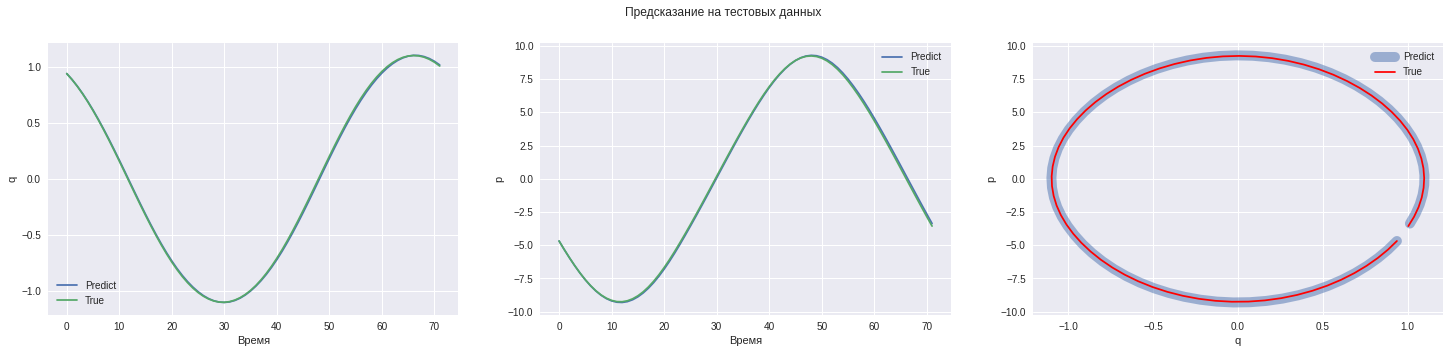

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

fig.suptitle(r'Предсказание на тестовых данных')

ax[0].plot(q, label='Predict')
ax[0].plot(x_test[0, :frame, 0], label='True')
ax[0].legend(), ax[0].set_xlabel('Время'), ax[0].set_ylabel(r'q')

ax[1].plot(p, label='Predict')
ax[1].plot(x_test[0, :frame, 1], label='True')
ax[1].legend(), ax[1].set_xlabel('Время'), ax[1].set_ylabel(r'p')

ax[2].plot(q, p, label='Predict', lw=10, alpha=0.5)
ax[2].plot(x_test[0, :frame, 0], x_test[0, :frame, 1], label='True', c='red'), ax[2].axis('tight')
ax[2].legend(), ax[2].set_xlabel(r'q'), ax[2].set_ylabel(r'p')

fig.savefig('/content/drive/MyDrive/Курсовая/Pendulum/result_HNN_test', dpi=300)
print('')

print('')

In [ ]:
MSE = 0

for i in range(50):
  q, p = integrate_HNN(hnn, [0, frame/24], (x_test[i, 0, :]), (2, 200, 200, 2), t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']
  MSE += sum((x_test[i, :frame, 0] - q)**2 + (x_test[i, :frame, 1] - p) ** 2) / frame

print(f'MSE test = {MSE / 50 : 0.6f}')



MSE test =  0.007895


In [ ]:
qs = (np.random.random(10) - 0.5) * np.pi 
ps = (np.random.random(10) - 0.5) * 20 
losses_by_frame = []
def check_loss(frame):
  
  data_test = give_data(size=50, frames=frame, qstarts=qs, pstarts=ps, drop=50)
  x_test = data_test[:, :, :2]
  y_test = data_test[:, :, :2]
  MSE = 0

  for i in range(50):
    q, p = integrate_HNN(hnn, [0, frame/24], (x_test[i, 0, :]), (2, 200, 200, 2), t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']
    MSE += sum((x_test[i, :frame, 0] - q)**2 + (x_test[i, :frame, 1] - p) ** 2) / frame

  return MSE / 50

for f in range(24, 144, 5):
  losses_by_frame.append(check_loss(f))

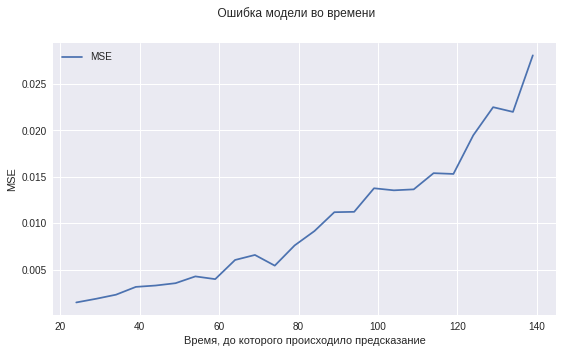

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

fig.suptitle(r' Ошибка модели во времени ')

plt.plot(np.arange(24, 144, 5), losses_by_frame, label='MSE')
ax.set_xlabel('Время, до которого происходило предсказание'), ax.set_ylabel('MSE')
ax.legend()

fig.savefig('/content/drive/MyDrive/Курсовая/Pendulum/MSE_test', dpi=300)
print('')



In [ ]:
frame = 288
x_test = give_data(size=1, frames=frame, qstarts=x_test[0, 0, :1], pstarts=x_test[0, 0, 1:])[:, :, :2]
x = 2 * np.sin(x_test[0, :, 0])
y = 2 * -np.cos(x_test[0, :, 0])

q, p = integrate_HNN(hnn, [0, frame/24], 
                     (x_test[0, 0, :]), 
                     (2, 200, 200, 2), 
                     t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']

x_pred = 2 * np.sin(q)
y_pred = 2 * -np.cos(q)

Create_Plot_with_predict('/content/drive/MyDrive/Курсовая/Pendulum/predict_by_HNN', x, y, x_pred, y_pred, [np.nan]*frame, [np.nan]*frame, frame)

# Создание визуализации маятника

In [ ]:
frame = 288
x_test = give_data(size=1, frames=frame, qstarts=[-1], pstarts=[7])[:, :, :2]
x = 2 * np.sin(x_test[0, :, 0])
y = 2 * -np.cos(x_test[0, :, 0])

q, p = integrate_HNN(hnn, [0, frame/24], 
                     (x_test[0, 0, :]), 
                     (2, 200, 200, 2), 
                     t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']

x_pred = 2 * np.sin(q)
y_pred = 2 * -np.cos(q)

Create_Plot_with_predict('/content/drive/MyDrive/Курсовая/Pendulum/predict_by_HNN', x, y, x_pred, y_pred, frame)

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib import animation 

def Create_Plot_with_predict(path, x, y, x_HNN, y_HNN, x_BNN, y_BNN, frames=72, name='Два маятника. Предсказанный и настоящий'): 

  L = 1.5
  # Создаем временную шкалу
  fps = 24 # Количество кадров в секунду
  TimeFinal = frames/fps # Количество секунд видео
  TimeAmount = int(TimeFinal*fps)
  AxisTime = np.linspace(0, TimeFinal, TimeAmount)
  dt = AxisTime[1] - AxisTime[0]

  # Создадим фигуру, на которой будет происходить отрисовка
  fig, ax = plt.subplots(figsize=(10, 10))
  plt.xlim(-L - 1, L + 1), plt.ylim(-L - 1, L + 1)
  Pendulum, = ax.plot([], [], 'o-', markersize=20, lw=2, markevery=100000, c='red', alpha = 0.5, label='Настоящий маятник')
  Pendulum_HNN, = ax.plot([], [], 'o-', markersize=20, lw=2, markevery=100000, c='navy', alpha = 0.5, label='Предсказанный с HNN маятник')
  Pendulum_BNN, = ax.plot([], [], 'o-', markersize=20, lw=2, markevery=100000, c='peachpuff', alpha = 0.5, label='Предсказанный с BNN маятник')
  CenterDot, = ax.plot([], [], 'o', markersize=7,c='grey')
  TimeOnPlot = ax.text(0.05, 0.9, '', transform=ax.transAxes) # Время будет отрисовываться в точке 0.05 по оХ и 0.9 
                                                              # по оY относительно всего графика

  #ax.annotate('', xy=(L, 0),  xytext=(-L, 0), arrowprops={'arrowstyle': '->'}, va='center') # Оси 
  #ax.annotate('', xy=(0, L),  xytext=(0, -L), arrowprops={'arrowstyle': '->'}, va='center')
  ax.get_xaxis().set_ticks([]),  ax.get_yaxis().set_ticks([])
  ax.set_title(name)
  plt.legend()
  plt.close('all')

  def animate(i): # Функция, которая на i-ом шаге отрисовывает данные
    Pendulum_HNN.set_data(x_HNN[i:i-5:-1], y_HNN[i:i-5:-1])   
    Pendulum_BNN.set_data(x_BNN[i:i-5:-1], y_BNN[i:i-5:-1])  
    Pendulum.set_data(x[i:i-5:-1], y[i:i-5:-1]) # Сам маятник 
    CenterDot.set_data([0, 0], [0, 0]) # Подвес
  
    TimeOnPlot.set_text(f'Time = {i * dt : 0.3f}s') # Отрисовываем время
    return Pendulum_HNN, Pendulum_BNN, Pendulum, CenterDot #, TimeOnPlot

  anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=0.5)
  anim.save(f'{path}.mp4', fps = fps, dpi = 100)


# Обычная нейроная сеть

In [ ]:
def BNN(shapes=(4, 200, 200, 2)):
  model = tf.keras.Sequential([
                               tf.keras.Input(shapes[0]),
                               tf.keras.layers.Dense(shapes[1], activation='tanh'),
                               tf.keras.layers.Dense(shapes[2], activation='tanh'),
                               tf.keras.layers.Dense(2, activation='linear')])
  

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.MeanSquaredError())
  
  return model

def integrate_BNN(model, t, y0, **kwargs):

  def S_h(t, x):
    x = tf.reshape(x, (1, 2))
    dx = model.predict(x)
    return dx

  return solve_ivp(S_h, t, y0, **kwargs)

In [ ]:
# Создание данных
data = give_data(size=50, frames=72, qstarts=np.linspace(-np.pi/2, np.pi/2, 5, endpoint=True), pstarts=np.linspace(-10, 10, 10, endpoint=True))
data = np.concatenate(data, axis=0)
x = data[:, :2]
y = data[:, 2:]

In [ ]:
# Создание и обучение сети
bnn = BNN((2, 200, 200, 2))
history = bnn.fit(x, y, batch_size = 72, epochs=500, verbose=0)

In [ ]:
# Созранение модели
bnn.save('/content/drive/MyDrive/Курсовая/Pendulum/ModelBNN/ModelBNN')

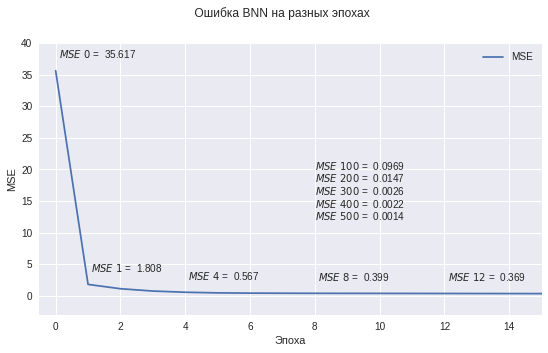

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

fig.suptitle(r' Ошибка BNN на разных эпохах ')

ax.plot(history.history['loss'], label='MSE')
ax.set_xlabel('Эпоха'), ax.set_ylabel('MSE')
ax.legend(), ax.set_xlim(-0.5, 15), ax.set_ylim(-3, 40)

for i in [0, 1, 4, 8, 12]:

  ax.annotate(f'$ MSE \ {i} $ = {history.history["loss"][i] : .3f}', (i+0.1, history.history["loss"][i] + 2))

ax.annotate(f'$ MSE \ {100} $ = {history.history["loss"][100] : .4f}', (8, 20))
ax.annotate(f'$ MSE \ {200} $ = {history.history["loss"][200] : .4f}', (8, 18))
ax.annotate(f'$ MSE \ {300} $ = {history.history["loss"][300] : .4f}', (8, 16))
ax.annotate(f'$ MSE \ {400} $ = {history.history["loss"][400] : .4f}', (8, 14))
ax.annotate(f'$ MSE \ {500} $ = {history.history["loss"][499] : .4f}', (8, 12))
fig.savefig('/content/drive/MyDrive/Курсовая/Pendulum/MSE_train_BNN', dpi=300)
print('')

In [ ]:
# Создание тестовых даннх
frame = 72
qs = (np.random.random(10) - 0.5) * np.pi 
ps = (np.random.random(10) - 0.5) * 20 
data_test = give_data(size=50, frames=frame, qstarts=qs, pstarts=ps, drop=50)
x_test = data_test[:, :, :2]
y_test = data_test[:, :, :2]


In [ ]:
# Первый взгляд на модель
q, p = integrate_BNN(bnn, [0, frame/24], (x_test[0, 0, :]), t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']

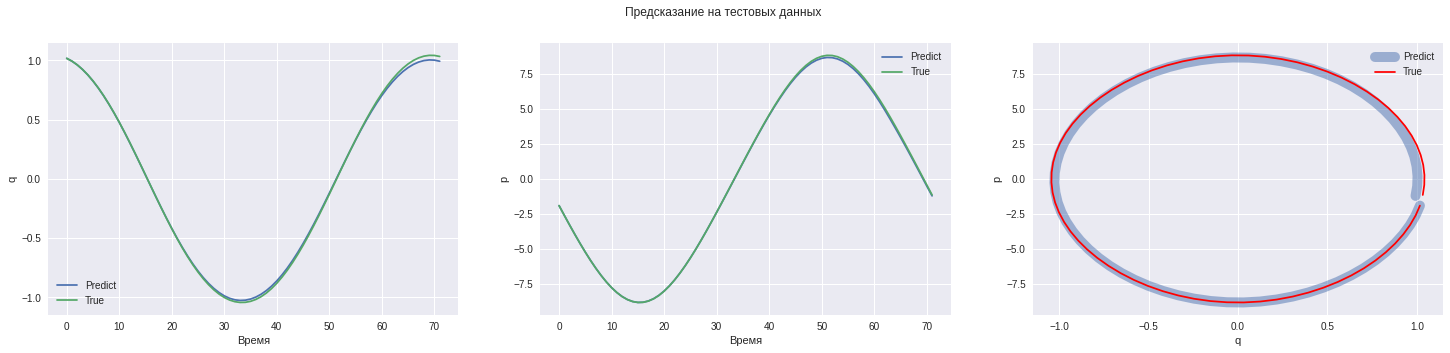

In [ ]:
# Отрисовка результатов
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

fig.suptitle(r'Предсказание на тестовых данных')

ax[0].plot(q, label='Predict')
ax[0].plot(x_test[0, :frame, 0], label='True')
ax[0].legend(), ax[0].set_xlabel('Время'), ax[0].set_ylabel(r'q')

ax[1].plot(p, label='Predict')
ax[1].plot(x_test[0, :frame, 1], label='True')
ax[1].legend(), ax[1].set_xlabel('Время'), ax[1].set_ylabel(r'p')

ax[2].plot(q, p, label='Predict', lw=10, alpha=0.5)
ax[2].plot(x_test[0, :frame, 0], x_test[0, :frame, 1], label='True', c='red'), ax[2].axis('tight')
ax[2].legend(), ax[2].set_xlabel(r'q'), ax[2].set_ylabel(r'p')

fig.savefig('/content/drive/MyDrive/Курсовая/Pendulum/result_BNN_test', dpi=300)
print('')


In [ ]:
# Подсчет ошибки на всех 50 начальных условиях и 72 кадрах
MSE = 0

for i in range(1):
  q, p = integrate_BNN(bnn, [0, frame/24], (x_test[i, 0, :]), t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']
  MSE += sum((x_test[i, :frame, 0] - q)**2 + (x_test[i, :frame, 1] - p) ** 2) / frame

print(f'MSE test = {MSE / 50 : 0.6f}')



MSE test =  0.000141


In [ ]:
# Подсчет потерь на данных c разным количеством данных
losses_by_frame_bnn = []
def check_loss(frame):
  
  data_test = give_data(size=50, frames=frame, qstarts=qs, pstarts=ps, drop=50)
  x_test = data_test[:, :, :2]
  y_test = data_test[:, :, :2]
  MSE = 0

  # Интегрирование этой BNN происходит очень ммедленно, поэтому мы возьмем только 5 случайных НУ
  for i in np.random.randint(0, 50, size=5):
    q, p = integrate_BNN(bnn, [0, frame/24], (x_test[i, 0, :]),  t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']
    MSE += sum((x_test[i, :frame, 0] - q)**2 + (x_test[i, :frame, 1] - p) ** 2) / frame

  return MSE / 50

for f in range(24, 144, 5):
  losses_by_frame.append(check_loss(f))

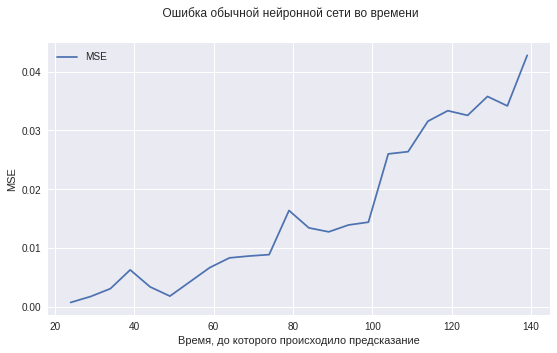

In [ ]:
# Отрисовка 
fig, ax = plt.subplots(figsize=(9, 5))

fig.suptitle(r' Ошибка обычной нейронной сети во времени ')

plt.plot(np.arange(24, 144, 5), losses_by_frame, label='MSE')
ax.set_xlabel('Время, до которого происходило предсказание'), ax.set_ylabel('MSE')
ax.legend()

fig.savefig('/content/drive/MyDrive/Курсовая/Pendulum/MSE_test_BNN', dpi=300)
print('')



In [ ]:
# Создание видео
frame = 288
x_test = give_data(size=1, frames=frame, qstarts=[-np.pi/4], pstarts=[7])[:, :, :2]
x = 2 * np.sin(x_test[0, :, 0])
y = 2 * -np.cos(x_test[0, :, 0])

q, p = integrate_BNN(bnn, [0, frame/24], 
                     (x_test[0, 0, :]), 
                     t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']

x_BNN = 2 * np.sin(q)
y_BNN = 2 * -np.cos(q)

q, p = integrate_HNN(hnn, [0, frame/24], 
                     (x_test[0, 0, :]), 
                     (2, 200, 200, 2), 
                     t_eval=np.linspace(0, frame/24, frame, endpoint=True))['y']

x_HNN = 2 * np.sin(q)
y_HNN = 2 * -np.cos(q)

Create_Plot_with_predict('/content/drive/MyDrive/Курсовая/Pendulum/predict_two_models', x, y, x_HNN, y_HNN, x_BNN, y_BNN,
                         frames=288, name='Сравнение двух моделей ГНС и ОНС.')

In [ ]:
# Запись в гиф
from moviepy.editor import VideoFileClip
clip = VideoFileClip('/content/drive/MyDrive/Курсовая/Pendulum/predict_two_models.mp4')
clip.write_gif('/content/drive/MyDrive/Курсовая/Pendulum/predict_two_models.gif')


[MoviePy] Building file /content/drive/MyDrive/Курсовая/Pendulum/predict_two_models.gif with imageio


100%|█████████▉| 288/289 [00:34<00:00,  8.25it/s]
